In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [ ]:
"""!apt-get update
!apt-get install -y libsndfile1"""

import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

import sys
print(sys.version)

2.15.0
2.15.0
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


# Importing Data

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#preparing data set

ravdess = "/content/drive/MyDrive/Data/revdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_16', 'Actor_21', 'Actor_17', 'Actor_10', 'Actor_20', 'Actor_11', 'Actor_19', 'Actor_18', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_02', 'Actor_23', 'Actor_22', 'Actor_09', 'Actor_15', 'Actor_14', 'Actor_12', 'Actor_13', 'Actor_24', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']


In [ ]:
Crema = "/content/drive/MyDrive/Data/AudioWAV/"
Tess = "/content/drive/MyDrive/Data/TESS-Toronto-emotional-speech-set-data/"
Savee = "/content/drive/MyDrive/Data/ALL/"

# preprocessing

**Ravdees**

In [ ]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)


In [ ]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-03-01-01-02-08.wav
03
/content/drive/MyDrive/Data/revdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-05-01-01-02-16.wav
6
03-01-06-02-01-02-08.wav


In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



  Emotions                                               Path
0    angry  /content/drive/MyDrive/Data/revdess-emotional-...
1  neutral  /content/drive/MyDrive/Data/revdess-emotional-...
2      sad  /content/drive/MyDrive/Data/revdess-emotional-...
3      sad  /content/drive/MyDrive/Data/revdess-emotional-...
4    happy  /content/drive/MyDrive/Data/revdess-emotional-...
______________________________________________
      Emotions                                               Path
1435      fear  /content/drive/MyDrive/Data/revdess-emotional-...
1436  surprise  /content/drive/MyDrive/Data/revdess-emotional-...
1437      fear  /content/drive/MyDrive/Data/revdess-emotional-...
1438  surprise  /content/drive/MyDrive/Data/revdess-emotional-...
1439      fear  /content/drive/MyDrive/Data/revdess-emotional-...
_______________________________________________
Emotions
neutral     288
angry       192
sad         192
happy       192
fear        192
disgust     192
surprise    192
Name: count, dty

**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
angry      1271
happy      1271
disgust    1271
fear       1271
sad        1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

valid_emotions = ['happy', 'sad', 'disgust', 'fear', 'angry', 'neutral', 'surprise']

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        try:
            emotion_part = part.split('_')[2]  # Attempt to access the third part
        except IndexError:
            print(f"Skipping file due to unexpected filename format: {file}")
            continue  # Skip this file and move to the next
        # Check if the extracted part is a recognized emotion
        if emotion_part in valid_emotions:
            file_emotion.append(emotion_part)
        elif emotion_part == 'ps':
            file_emotion.append('surprise')
        else:
            # Log unexpected emotion types or handle them separately
            print(f"Unexpected emotion type in filename: {file}")
            continue  # Optionally skip adding this file to the lists

        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
disgust     400
angry       400
happy       400
sad         400
fear        400
neutral     400
surprise    400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
happy        60
angry        60
fear         60
disgust      60
surprise     60
sad          60
Name: count, dtype: int64


**Integration**

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/Data/revdess-emotional-...
1,neutral,/content/drive/MyDrive/Data/revdess-emotional-...
2,sad,/content/drive/MyDrive/Data/revdess-emotional-...
3,sad,/content/drive/MyDrive/Data/revdess-emotional-...
4,happy,/content/drive/MyDrive/Data/revdess-emotional-...


In [ ]:
print(data_path.Emotions.value_counts())


Emotions
angry       1923
sad         1923
happy       1923
disgust     1923
fear        1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

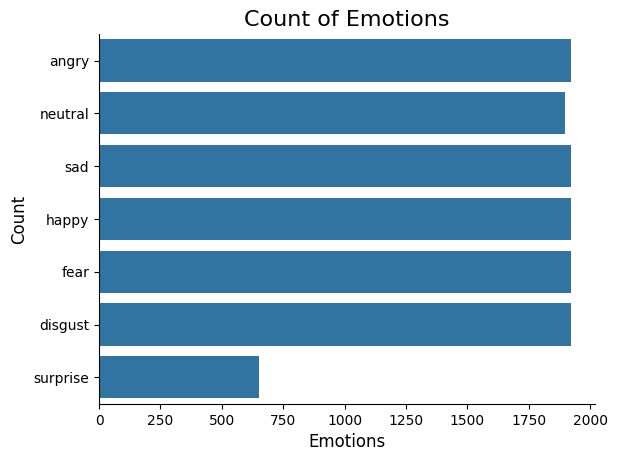

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
data,sr = librosa.load(file_path[0])
sr

22050

In [ ]:
ipd.Audio(data,rate=sr)

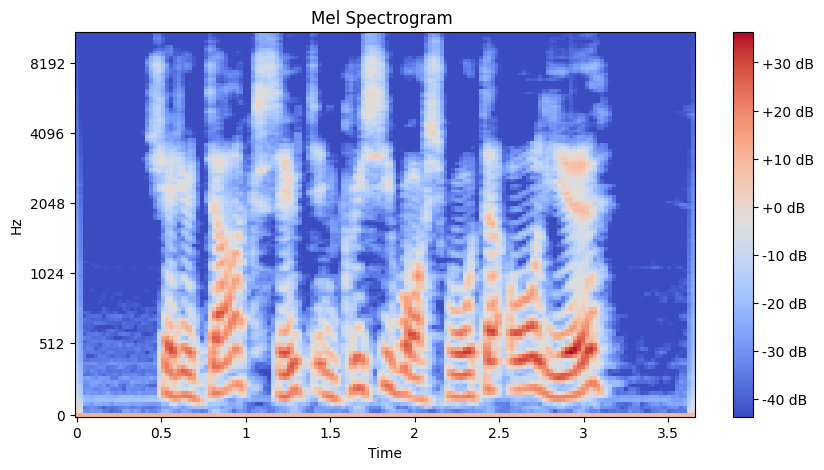

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB');

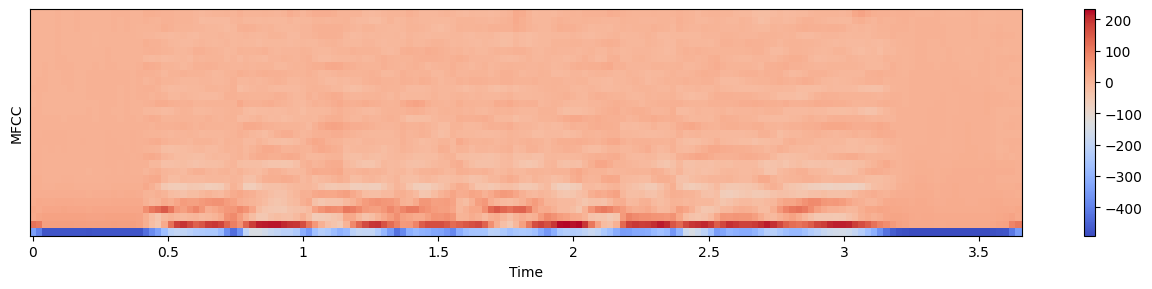

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    # Use keyword arguments to specify parameters for the pitch_shift function
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)


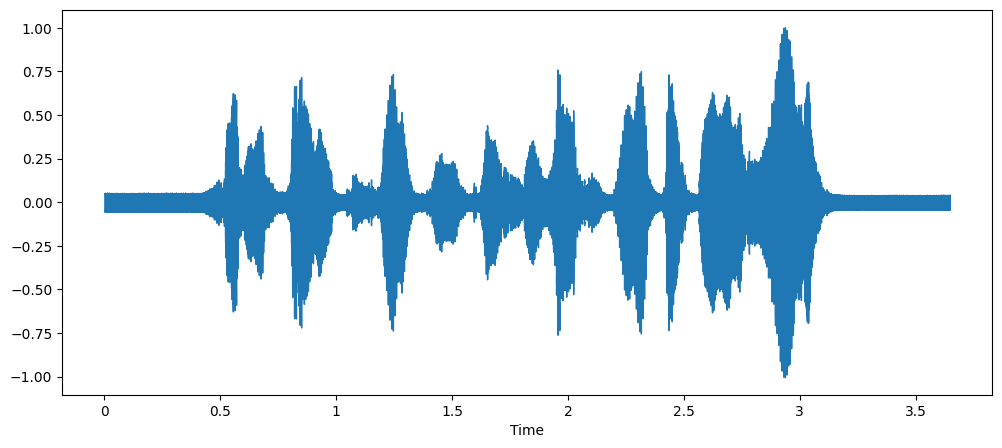

In [ ]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

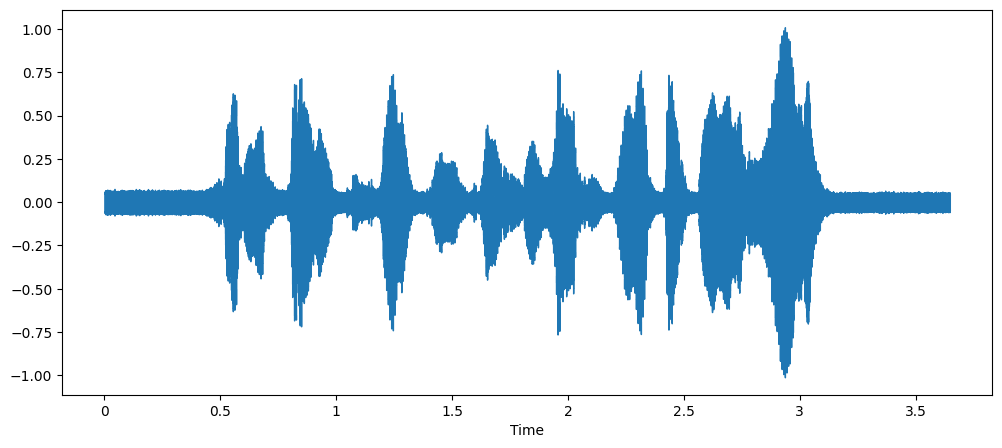

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [ ]:
# STRETCHED AUDIO
#x = stretch(data)
#plt.figure(figsize=(12, 5))
#librosa.display.waveshow(y=x, sr=sr)
#ipd.Audio(x, rate=sr)

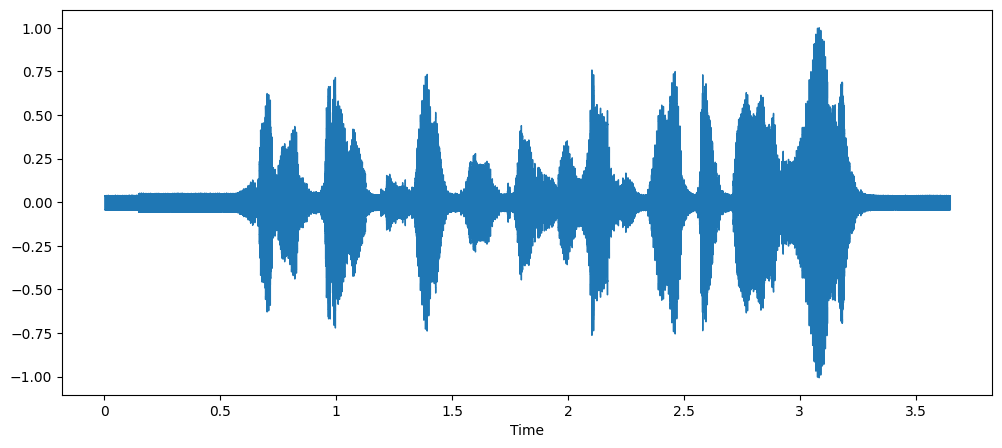

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

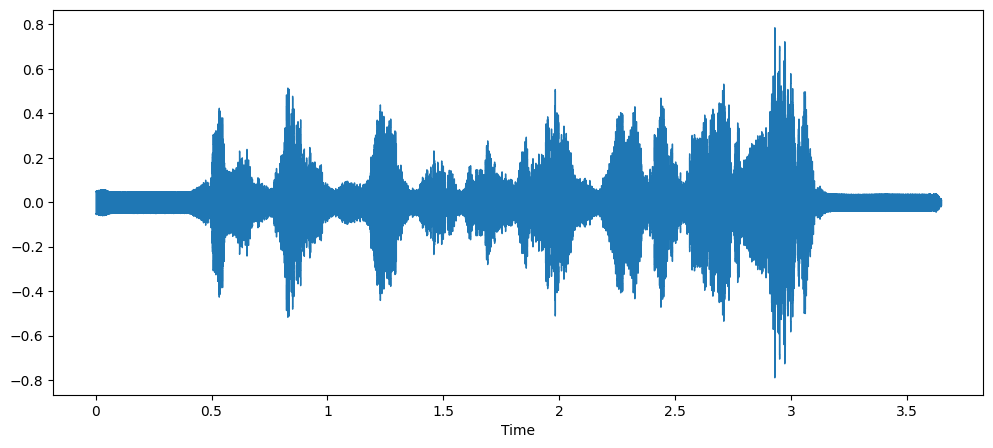

In [ ]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    # Correctly passing `y=data` as a keyword argument
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    # Ensure to pass `y=data` as a keyword argument
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=20, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


# Getting features

In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  1.08it/s]

0 audio has been processed


501it [05:40,  1.59it/s]

500 audio has been processed


1001it [11:05,  1.69it/s]

1000 audio has been processed


1501it [16:34,  1.73it/s]

1500 audio has been processed


2001it [21:35,  1.75it/s]

2000 audio has been processed


2501it [26:53,  1.50it/s]

2500 audio has been processed


3001it [31:59,  1.39it/s]

3000 audio has been processed


3501it [37:04,  1.44it/s]

3500 audio has been processed


4001it [42:08,  1.67it/s]

4000 audio has been processed


4501it [47:08,  1.49it/s]

4500 audio has been processed


5001it [52:19,  1.71it/s]

5000 audio has been processed


5501it [57:20,  1.80it/s]

5500 audio has been processed


6001it [1:02:30,  1.45it/s]

6000 audio has been processed


6501it [1:07:38,  1.87it/s]

6500 audio has been processed


7001it [1:12:39,  1.55it/s]

7000 audio has been processed


7501it [1:17:43,  1.64it/s]

7500 audio has been processed


8001it [1:22:52,  1.70it/s]

8000 audio has been processed


8501it [1:27:55,  1.68it/s]

8500 audio has been processed


9001it [1:33:07,  1.61it/s]

9000 audio has been processed


9501it [1:37:58,  1.44it/s]

9500 audio has been processed


10001it [1:42:55,  1.87it/s]

10000 audio has been processed


10501it [1:47:58,  1.52it/s]

10500 audio has been processed


11001it [1:52:52,  1.95it/s]

11000 audio has been processed


11501it [1:58:02,  1.63it/s]

11500 audio has been processed


12001it [2:03:27,  1.58it/s]

12000 audio has been processed


12162it [2:05:11,  1.62it/s]

Done
Time:  7511.793442819


In [ ]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

# Saving features

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.413574,0.626465,0.813965,0.814453,0.809082,0.782715,0.808105,0.766602,0.740234,0.741699,...,-6.684464,-8.185219,-2.864520,2.624074,1.601874,-4.651927,-6.910088,-1.790279,1.269426,angry
1,0.243652,0.366699,0.488770,0.490723,0.504395,0.504883,0.509277,0.494141,0.489746,0.486328,...,5.937312,2.978974,-1.116819,-3.526292,-6.076828,-2.629266,-0.472527,2.131672,-5.118666,angry
2,0.192383,0.266113,0.327637,0.290039,0.281250,0.290039,0.311035,0.316895,0.303711,0.307129,...,-12.227371,-9.180283,-2.152683,2.856705,1.739628,-3.435292,-4.571471,-2.029370,-2.928011,angry
3,0.244141,0.367676,0.497559,0.505859,0.506836,0.510254,0.503418,0.500000,0.496094,0.507324,...,-0.155222,1.649420,-0.997770,-0.816133,1.873948,-2.341637,-3.604921,-0.749814,2.860074,angry
4,0.406250,0.600098,0.795410,0.812988,0.829590,0.738281,0.750977,0.756836,0.736328,0.732422,...,-7.463809,-1.991697,3.364694,3.279373,-0.220712,-1.898432,-1.059373,-0.917537,-2.517284,neutral


In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.413574,0.626465,0.813965,0.814453,0.809082,0.782715,0.808105,0.766602,0.740234,0.741699,...,-6.684464,-8.185219,-2.864520,2.624074,1.601874,-4.651927,-6.910088,-1.790279,1.269426,angry
1,0.243652,0.366699,0.488770,0.490723,0.504395,0.504883,0.509277,0.494141,0.489746,0.486328,...,5.937312,2.978974,-1.116819,-3.526292,-6.076828,-2.629266,-0.472527,2.131672,-5.118666,angry
2,0.192383,0.266113,0.327637,0.290039,0.281250,0.290039,0.311035,0.316895,0.303711,0.307129,...,-12.227371,-9.180283,-2.152683,2.856705,1.739628,-3.435292,-4.571471,-2.029370,-2.928011,angry
3,0.244141,0.367676,0.497559,0.505859,0.506836,0.510254,0.503418,0.500000,0.496094,0.507324,...,-0.155222,1.649420,-0.997770,-0.816133,1.873948,-2.341637,-3.604921,-0.749814,2.860074,angry
4,0.406250,0.600098,0.795410,0.812988,0.829590,0.738281,0.750977,0.756836,0.736328,0.732422,...,-7.463809,-1.991697,3.364694,3.279373,-0.220712,-1.898432,-1.059373,-0.917537,-2.517284,neutral


In [ ]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [ ]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
#Y = np.array(Y, dtype=str)  # Convert all elements to strings
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [ ]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [ ]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)


import os

# Create a directory to save CSV files if it doesn't exist
if not os.path.exists('csv_files'):
    os.makedirs('csv_files')

# Loop through each slice of the 3D array
for i, slice_2d in enumerate(X_train):
    # Generate a file name for the CSV file
    csv_file_path = os.path.join('csv_files', f'data_{i}.csv')
    # Save the slice to a CSV file
    np.savetxt(csv_file_path, slice_2d, delimiter=",")

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:

early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# CNN model

In [ ]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [ ]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.4),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.5),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.3),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=15, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/15
609/609 [==============================] - ETA: 0s - loss: 1.4565 - accuracy: 0.4411

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


609/609 [==============================] - 225s 340ms/step - loss: 1.4565 - accuracy: 0.4411 - val_loss: 1.4940 - val_accuracy: 0.3963 - lr: 0.0010
Epoch 2/15
609/609 [==============================] - 207s 340ms/step - loss: 1.1559 - accuracy: 0.5518 - val_loss: 1.3350 - val_accuracy: 0.4768 - lr: 0.0010
Epoch 3/15
609/609 [==============================] - 207s 340ms/step - loss: 1.0418 - accuracy: 0.5964 - val_loss: 1.1747 - val_accuracy: 0.5443 - lr: 0.0010
Epoch 4/15
609/609 [==============================] - 199s 326ms/step - loss: 0.9641 - accuracy: 0.6256 - val_loss: 0.9668 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 5/15
609/609 [==============================] - 206s 338ms/step - loss: 0.8602 - accuracy: 0.6701 - val_loss: 0.9366 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 6/15
609/609 [==============================] - 206s 338ms/step - loss: 0.7556 - accuracy: 0.7153 - val_loss: 1.0269 - val_accuracy: 0.6224 - lr: 0.0010
Epoch 7/15
609/609 [==============================] - 207

305/305 [==============================] - 17s 50ms/step - loss: 0.3265 - accuracy: 0.8864
Accuracy of our model on test data :  88.64337205886841 %


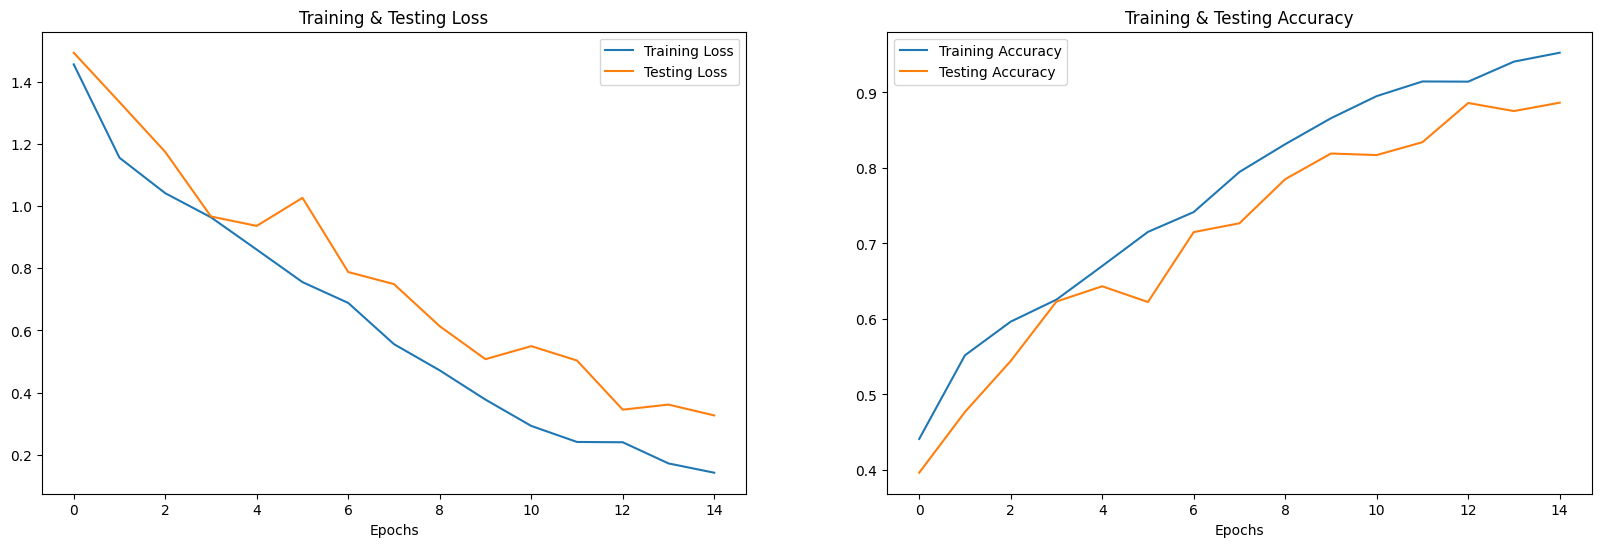

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 [==============================] - 14s 44ms/step


,Predicted Labels,Actual Labels
0,happy,happy
1,disgust,happy
2,neutral,sad
3,angry,angry
4,neutral,neutral
5,happy,happy
6,happy,happy
7,angry,angry
8,disgust,disgust
9,surprise,surprise


In [ ]:
df0

,Predicted Labels,Actual Labels
0,happy,happy
1,disgust,happy
2,neutral,sad
3,angry,angry
4,neutral,neutral
...,...,...
9725,disgust,disgust
9726,angry,angry
9727,angry,angry
9728,neutral,neutral


Some plots of multi_model
______________________________________________


# Evalutation

Results of best model

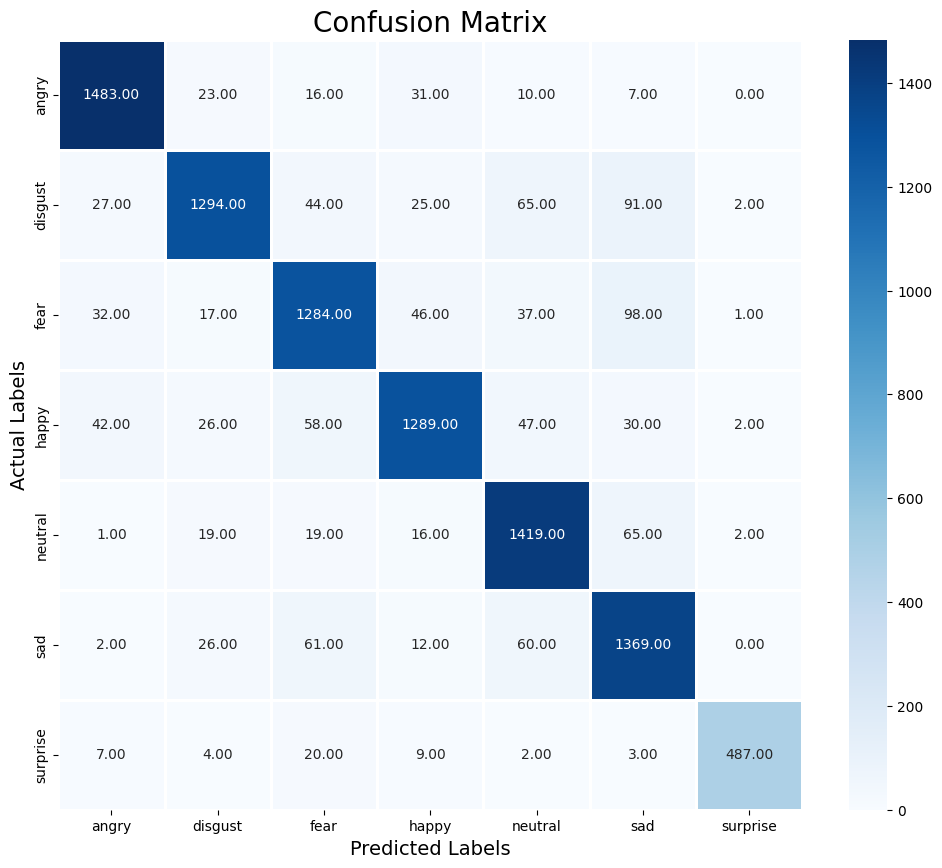

              precision    recall  f1-score   support

       angry       0.93      0.94      0.94      1570
     disgust       0.92      0.84      0.88      1548
        fear       0.85      0.85      0.85      1515
       happy       0.90      0.86      0.88      1494
     neutral       0.87      0.92      0.89      1541
         sad       0.82      0.89      0.86      1530
    surprise       0.99      0.92      0.95       532

    accuracy                           0.89      9730
   macro avg       0.90      0.89      0.89      9730
weighted avg       0.89      0.89      0.89      9730



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('confusion_matrix.png', format='png', bbox_inches='tight')
plt.show()
print(classification_report(y_test0, y_pred0))

In [ ]:
import numpy as np

# Calculate classification report
class_report = classification_report(y_test0, y_pred0, output_dict=True)

# Extract metrics for each emotion
emotions = list(encoder.categories_[0])  # Assuming encoder.categories_ contains emotion labels

# Create a DataFrame for classification report
classification_df = pd.DataFrame(class_report).transpose()

# Initialize a dictionary to store accuracy for each emotion
accuracy_per_emotion = {}

# Calculate accuracy for each emotion
for emotion in emotions:
    true_positives = classification_df.loc[emotion, 'precision'] * classification_df.loc[emotion, 'support']
    accuracy_per_emotion[emotion] = true_positives / classification_df.loc[emotion, 'support']

# Convert accuracy dictionary to DataFrame
accuracy_df = pd.DataFrame.from_dict(accuracy_per_emotion, orient='index', columns=['Accuracy'])

# Rename the index for better readability
accuracy_df.index.name = 'Emotion'

# Display the DataFrame
print(accuracy_df)

          Accuracy
Emotion           
angry     0.930364
disgust   0.918382
fear      0.854860
happy     0.902661
neutral   0.865244
sad       0.823211
surprise  0.985830


In [ ]:
import pandas as pd

# Calculate classification report
class_report = classification_report(y_test0, y_pred0, output_dict=True)

# Extract metrics for each emotion
emotions = list(encoder.categories_[0])  # Assuming encoder.categories_ contains emotion labels

# Create a DataFrame for classification report
classification_df = pd.DataFrame(class_report).transpose()

# Filter out metrics for each emotion
emotions_metrics = classification_df.loc[emotions, ['precision', 'recall', 'f1-score', 'support']]

# Rename the index for better readability
emotions_metrics.index.name = 'Emotion'

# Display the DataFrame
print(emotions_metrics)

          precision    recall  f1-score  support
Emotion                                         
angry      0.930364  0.944586  0.937421   1570.0
disgust    0.918382  0.835917  0.875211   1548.0
fear       0.854860  0.847525  0.851177   1515.0
happy      0.902661  0.862784  0.882272   1494.0
neutral    0.865244  0.920831  0.892172   1541.0
sad        0.823211  0.894771  0.857501   1530.0
surprise   0.985830  0.915414  0.949318    532.0


In [ ]:
# Merge accuracy DataFrame with emotions_metrics DataFrame
combined_df = pd.merge(emotions_metrics, accuracy_df, left_index=True, right_index=True)

# Display the combined DataFrame
print(combined_df)

          precision    recall  f1-score  support  Accuracy
Emotion                                                   
angry      0.930364  0.944586  0.937421   1570.0  0.930364
disgust    0.918382  0.835917  0.875211   1548.0  0.918382
fear       0.854860  0.847525  0.851177   1515.0  0.854860
happy      0.902661  0.862784  0.882272   1494.0  0.902661
neutral    0.865244  0.920831  0.892172   1541.0  0.865244
sad        0.823211  0.894771  0.857501   1530.0  0.823211
surprise   0.985830  0.915414  0.949318    532.0  0.985830


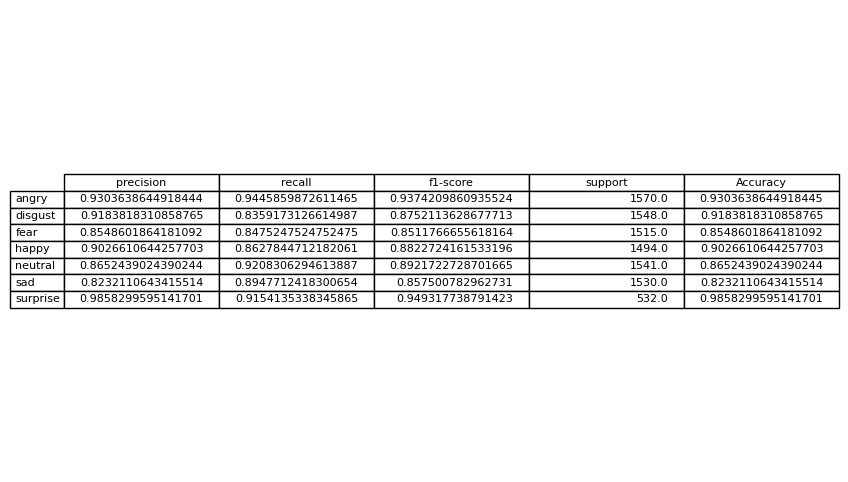

In [ ]:
import matplotlib.pyplot as plt

# Plot the DataFrame as a table
plt.figure(figsize=(10, 6))
plt.table(cellText=combined_df.values,
          colLabels=combined_df.columns,
          rowLabels=combined_df.index,
          loc='center')
plt.axis('off')  # Hide the axes

# Save the plot as a JPEG image
plt.savefig('combined_metrics_table.jpg', format='jpg', bbox_inches='tight', pad_inches=0.1)

# Show the plot (optional)
plt.show()

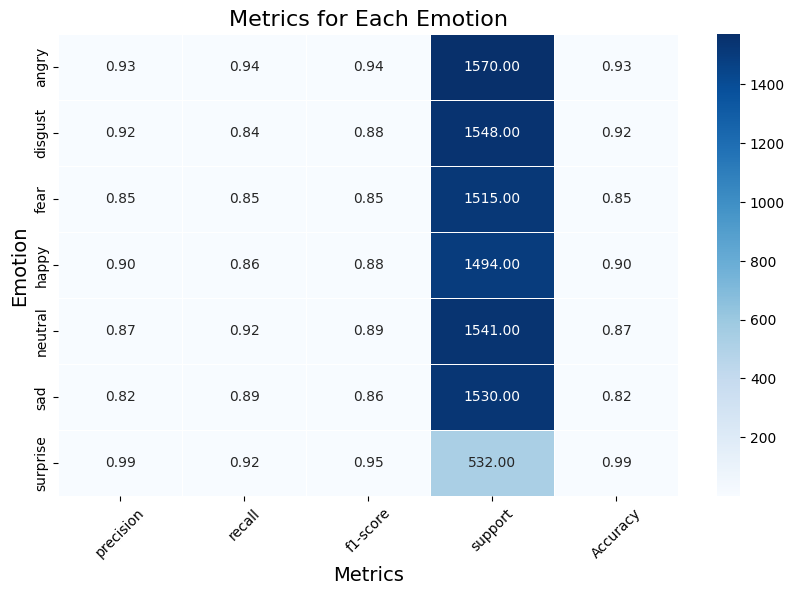

In [ ]:
import matplotlib.pyplot as plt

# Plot the DataFrame as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(combined_df, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
plt.title('Metrics for Each Emotion', size=16)
plt.xlabel('Metrics', size=14)
plt.ylabel('Emotion', size=14)
plt.xticks(rotation=45)

# Save the plot as a JPEG image
plt.savefig('combined_metrics.jpg', format='jpg')

# Show the plot (optional)
plt.show()

# Saving Best Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 [==============================] - 15s 47ms/step - loss: 0.3265 - accuracy: 0.8864
accuracy: 88.64%


# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [ ]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


# Test script
* That can predict new record

In [ ]:
from keras.models import Sequential, model_from_json
json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
import pickle

with open('/content/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

with open('/content/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


In [ ]:
import librosa
print(librosa.__version__)
import numpy as np
from sklearn.preprocessing import StandardScaler

0.10.2


In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
   #Correctly passing `y=data` as a keyword argument
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
     #Ensure to pass `y=data` as a keyword argument
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=20, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)


def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result



In [ ]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    #result=np.array(res)
    shape = res.shape
    # If the number of features is less than 2376, pad with zeros
    if shape[0] < 2376:
        pad_width = ((0, 2376 - shape[0]))  # Pad along the second axis
        res = np.pad(res, pad_width, mode='constant', constant_values=0)

    result = np.reshape(res, newshape=(1, -1))  # Reshape to (1, 2376) or whatever the shape is after padding

    #scaler2 = StandardScaler(n_features=2376)
    #result=np.reshape(result,newshape=(1,shape[0]))
    #scaler2.fit(result)
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result



In [ ]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

In [ ]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)

    print(y_pred[0][0])

In [ ]:
ipd.Audio("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav",rate=sr)

In [ ]:
prediction("/content/drive/MyDrive/Data/revdess-emotional-speech-audio/Actor_02/03-01-02-02-01-01-02.wav")

1/1 [==============================] - 0s 27ms/step
disgust


In [ ]:
ipd.Audio("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav",rate=sr)

In [ ]:
prediction("/content/drive/MyDrive/Data/TESS-Toronto-emotional-speech-set-data/OAF_Fear/OAF_bean_fear.wav")

1/1 [==============================] - 1s 1s/step
fear


In [ ]:
ipd.Audio("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav",rate=sr)

In [ ]:
prediction("/content/drive/MyDrive/Data/TESS-Toronto-emotional-speech-set-data/OAF_Fear/OAF_back_fear.wav")

1/1 [==============================] - 0s 52ms/step
fear


In [ ]:
ipd.Audio("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav",rate=sr)

In [ ]:
prediction("/content/drive/MyDrive/Data/AudioWAV/1001_DFA_HAP_XX.wav")

1/1 [==============================] - 0s 47ms/step
happy


In [ ]:
ipd.Audio("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav",rate=sr)

In [ ]:
prediction("/content/drive/MyDrive/Data/AudioWAV/1001_IEO_ANG_HI.wav")

1/1 [==============================] - 0s 33ms/step
angry


In [ ]:
ipd.Audio("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav",rate=sr)

In [ ]:
prediction("/content/drive/MyDrive/Data/AudioWAV/1001_IEO_DIS_MD.wav")

1/1 [==============================] - 0s 56ms/step
disgust


In [ ]:
ipd.Audio("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav",rate=sr)

In [ ]:
prediction("/content/drive/MyDrive/Data/AudioWAV/1001_IEO_HAP_MD.wav")

1/1 [==============================] - 0s 33ms/step
happy
